In [62]:
import time, ast, json, requests
import xgboost
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import datetime
from pprint import pprint
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn import svm, tree
# from sklearn.grid_search import GridSearchCV 

from scipy import stats

sns.set(color_codes=True)

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Load TFT Game Data

In [3]:
game_data = pd.read_csv('./tft_csv/complete_match_data.csv')
match_ids = pd.read_csv('./tft_csv/match_ids.csv')
player_data = pd.read_csv('./tft_csv/player_data.csv')

In [4]:
game_data.drop('Unnamed: 0', axis=1, inplace=True)
match_ids.drop('Unnamed: 0', axis=1, inplace=True)
player_data.drop('Unnamed: 0', axis=1, inplace=True)

# Load Extra TFT Data

In [5]:
tft_items = None
tft_traits = None
tft_champs = None
with open('./tft_extra_data/items.json') as json_file:
    tft_items = json.load(json_file)

with open('./tft_extra_data/traits.json') as json_file:
    tft_traits = json.load(json_file)

with open('./tft_extra_data/champions.json') as json_file:
    tft_champs = json.load(json_file)
    
temp_items = {}
for item in tft_items:
    temp_items[item['id']] = {'name': item['name'],
                              'tier': item['tier']
                             }
tft_items = temp_items

temp_traits = {}
for trait in tft_traits:
    temp_traits[trait['name']] = {'tier': trait['tier']}
    
tft_traits = temp_traits
tft_traits['Set2_Glacial'] = {'tier': 'B'}
tft_traits['Set2_Assassin'] = {'tier': 'A'}
tft_traits['Set2_Blademaster'] = {'tier': 'S'}
tft_traits['Set2_Ranger'] = {'tier': 'A'}
tft_traits['Metal'] = {'tier': 'A'}
tft_traits['Wind'] = {'tier': 'B'}
tft_traits['Soulbound'] = {'tier': 'A'}


# Manipulate Data Columns into Features

In [6]:
# Group Top/Bottom 4 Placements
game_data['game_won'] = [1 if p <= 4 else 0 for p in game_data['placement']]

### Champ + Tier Evaluation Attempt: #1

In [100]:
# Champion Evaluation
unit_powers = []
for u in game_data['units']:
    unit_lst = ast.literal_eval(u)
    unit_power = 0
    for unit in unit_lst:
        name = unit[0]
        rarity = unit[1]
        char_tier = unit[2]
        items = unit[3]
        
        item_power = 0
        for item in items:
            if item not in tft_items:
                continue
            item_data = tft_items[item]
            # print(item_data['name'], item_data['tier'])
            
            if item_data['tier'] == 'S':
                item_power += 3
            elif item_data['tier'] == 'A':
                item_power += 2
            elif item_data['tier'] == 'B':
                item_power += 1
            elif item_data['tier'] == 'S-':
                item_power += 2.5
            elif item_data['tier'] == 'A-':
                item_power += 1.5
            elif item_data['tier'] == 'B-':
                item_power += 0.5
        # print(unit)
        
        unit_power += (1 + rarity) * char_tier + item_power
    unit_powers.append(unit_power)

game_data['team_unit_power'] = unit_powers

In [101]:
# Class Evaluation
class_powers = []
for t in game_data['traits']:
    traits_lst = ast.literal_eval(t)
    class_bonus = 0

    for trait in traits_lst:
        #print(trait)
        trait_name = trait[0]
        trait_active_tier = trait[1]
        trait_power = 0
        
        if tft_traits[trait_name]['tier'] == 'S':
            trait_power += 3
        elif tft_traits[trait_name]['tier'] == 'A':
            trait_power += 2
        elif tft_traits[trait_name]['tier'] == 'B':
            trait_power += 1
        elif tft_traits[trait_name]['tier'] == 'C':
            trait_power += 0.5
        
        if trait_active_tier == 1:
            active_tier_multiplier = 0.4
        else:
            active_tier_multiplier = trait_active_tier/10
        
        class_bonus += trait_power * (1 + active_tier_multiplier)
        
    class_powers.append(class_bonus)
game_data['class_powers'] = class_powers

# Split Data for Test/Train

In [9]:
game_data.head(8)

,puuid,match_id,game_length,gold_left,last_round,level,placement,players_eliminated,time_eliminated,total_damage_to_players,traits,units,game_won,team_unit_power,class_powers
0,HbYsPpRS3X2RaQ8n5Sm9n2gKU80f927PzBk_krw4kdyRG6...,NA1_3249805878,1959.947266,5,31,8,4,0,1714.102783,95,"[('Berserker', 2), ('Desert', 0), ('Electric',...","[('Renekton', 0, 2, []), ('DrMundo', 2, 2, [])...",1,52,16.6
1,OkaQSLZuy-FUjgfc_a770gWAvOtn5WLYcBN7toyVLJsc1d...,NA1_3249805878,1959.947266,0,35,9,2,3,1951.685059,146,"[('Avatar', 1), ('Electric', 3), ('Inferno', 1...","[('Annie', 3, 2, []), ('Zed', 4, 2, [24, 66, 1...",1,91,26.0
2,HGeDGOQrklxGiScizUCLq_BVn5gTYBy-DldOuy38XcaKap...,NA1_3249805878,1959.947266,0,31,7,5,0,1711.923218,72,"[('Berserker', 0), ('Desert', 2), ('Inferno', ...","[('Nocturne', 2, 2, [19, 19, 23]), ('Sivir', 2...",0,52,14.8
3,VyCpwiJ3MifHEREwjj0cSAXHQIjFGd7UtWMBG9ZvCdlGso...,NA1_3249805878,1959.947266,30,26,7,7,0,1445.723633,55,"[('Inferno', 1), ('Light', 0), ('Mountain', 0)...","[('Kindred', 2, 2, [44, 22, 39]), ('Malzahar',...",0,57,20.8
4,UsiShYgxH3X5_pNeJjE-EpBhbR4vevorLcs83aI8ZSQFaZ...,NA1_3249805878,1959.947266,4,33,8,3,0,1819.271362,129,"[('Avatar', 1), ('Desert', 1), ('Inferno', 0),...","[('Yasuo', 1, 2, []), ('Sivir', 2, 2, [25, 46,...",1,73,23.0
5,BXPswgAxjGfAfQHvaF-m7CtUdbBvZQhcviLqZwZDyDZbDn...,NA1_3249805878,1959.947266,50,28,8,6,0,1567.998779,80,"[('Inferno', 1), ('Light', 0), ('Mage', 0), ('...","[('Nami', 4, 1, [25, 57]), ('Thresh', 1, 2, [6...",0,61,22.4
6,zqelCdkKSSNGoCJA9msW7sP-wmzIW0HPG8b8ElUMwLCIMl...,NA1_3249805878,1959.947266,8,24,7,8,0,1324.369019,31,"[('Desert', 1), ('Inferno', 0), ('Light', 0), ...","[('Aatrox', 2, 2, []), ('Nocturne', 2, 2, [19,...",0,48,13.6
7,BXZMHIfauv8M3BuaqO6wZnxQXrN2flWKj1GhJ6nNQeP3DD...,NA1_3249805878,1959.947266,1,35,9,1,4,1951.685059,176,"[('Avatar', 1), ('Crystal', 0), ('Electric', 0...","[('Malphite', 3, 2, []), ('Lux', 5, 1, []), ('...",1,89,31.4


In [102]:
# feature_columns = ['gold_left', 'level','players_eliminated', 'total_damage_to_players']
feature_columns = ['team_unit_power',
                   'class_powers',
                   'players_eliminated',
                   'total_damage_to_players',
#                    'gold_left',
#                    'level'
                  ]
X = game_data[feature_columns]
y = game_data['game_won']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

### Logistic Regression

In [103]:
# Feature Elimination
logreg = LogisticRegression()
rfe = RFE(logreg, 20)
rfe = rfe.fit(X_train, y_train)
print(rfe.support_)
print(rfe.ranking_)

[ True  True  True  True]
[1 1 1 1]


In [104]:
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.325575
         Iterations 8
                             Results: Logit
Model:                 Logit              Pseudo R-squared:   0.530     
Dependent Variable:    game_won           AIC:                10509.7574
Date:                  2020-01-04 13:26   BIC:                10540.5106
No. Observations:      16128              Log-Likelihood:     -5250.9   
Df Model:              3                  LL-Null:            -11179.   
Df Residuals:          16124              LLR p-value:        0.0000    
Converged:             1.0000             Scale:              1.0000    
No. Iterations:        8.0000                                           
------------------------------------------------------------------------
                         Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------------
team_unit_power         -0.0838   0.0031 -27.1395 0

In [105]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))


Accuracy of logistic regression classifier on test set: 0.89


In [106]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.91      0.89      2374
           1       0.91      0.88      0.90      2465

    accuracy                           0.89      4839
   macro avg       0.89      0.90      0.89      4839
weighted avg       0.90      0.89      0.89      4839



### Decision Tree

In [107]:
model_dt = tree.DecisionTreeClassifier()
model_dt.fit(X_train, y_train)
y_pred= model_dt.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print("Accuracy of %s is %s"%(model_dt, acc))


Accuracy of DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best') is 0.9266377350692292


In [108]:
pd.Series(model_dt.feature_importances_,index=feature_columns).sort_values(ascending=False)

total_damage_to_players    0.755999
class_powers               0.131397
team_unit_power            0.093343
players_eliminated         0.019261
dtype: float64

### Random Forest

In [109]:
model_rfc = RandomForestClassifier(n_estimators=200)
model_rfc.fit(X_train, y_train)
y_pred= model_rfc.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print("Accuracy of %s is %s"%(model_rfc, acc))

Accuracy of RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False) is 0.943170076462079


In [110]:
rf_feature_importance = pd.Series(model_rfc.feature_importances_,index=feature_columns).sort_values(ascending=False)
rf_feature_importance

total_damage_to_players    0.556631
team_unit_power            0.208219
class_powers               0.128198
players_eliminated         0.106952
dtype: float64

#### Random Forest Paramter Tuning

In [61]:
rf = RandomForestRegressor(random_state=420)
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 'warn',
 'n_jobs': None,
 'oob_score': False,
 'random_state': 420,
 'verbose': 0,
 'warm_start': False}


In [63]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap
              }
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [65]:
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator=rf, 
                               param_distributions=random_grid, 
                               n_iter=100, 
                               cv=3, 
                               verbose=2, 
                               random_state=420, 
                               n_jobs=-1)
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 11.0min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   random_sta...


In [66]:
pprint(rf_random.best_params_)

{'bootstrap': True,
 'max_depth': 90,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 1800}


In [111]:
model_rfc_tuned = RandomForestClassifier(n_estimators=1800, 
                                   bootstrap=True, 
                                   max_depth=90,
                                   max_features='sqrt',
                                   min_samples_leaf=1,
                                   min_samples_split=2
                                  )
model_rfc_tuned.fit(X_train, y_train)
y_pred= model_rfc_tuned.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print("Accuracy of %s is %s"%(model_rfc_tuned, acc))

Accuracy of RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=90, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1800,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False) is 0.9433767307294896


In [112]:
rf_tuned_feature_importance = pd.Series(model_rfc_tuned.feature_importances_,index=feature_columns).sort_values(ascending=False)
rf_tuned_feature_importance

total_damage_to_players    0.527788
team_unit_power            0.242971
class_powers               0.128201
players_eliminated         0.101040
dtype: float64

In [99]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix of %s is \n%s"%(model_rfc_tuned, cm))

Confusion Matrix of RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=90, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1800,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False) is 
[[2274  134]
 [ 168 2263]]


### SVM

In [113]:
# SVM
model_svm = svm.SVC(kernel='linear') # linear, rbf, sigmoid, polynomial
model_svm.fit(X_train, y_train)
y_pred = model_svm.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Accuracy of %s is %s"%(model_svm, acc))


Accuracy of SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False) is 0.8941930150857615


In [114]:
model_svm.coef_, feature_columns

(array([[ 0.0466912 , -0.00845251,  0.52245431,  0.05154237]]),
 ['team_unit_power',
  'class_powers',
  'players_eliminated',
  'total_damage_to_players'])

# XGBoost

In [115]:
# Extreme Gradient Boost
model_xg = xgboost.XGBClassifier()
model_xg.fit(X_train, y_train)
y_pred = model_xg.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Accuracy of %s is %s" % (model_xg, acc))

Accuracy of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1) is 0.8946063236205828


In [52]:
sum(model_xg.feature_importances_.tolist())

1.0000000223517418

In [116]:
model_xg.feature_importances_, feature_columns

(array([0.06017964, 0.01340315, 0.06486427, 0.86155295], dtype=float32),
 ['team_unit_power',
  'class_powers',
  'players_eliminated',
  'total_damage_to_players'])

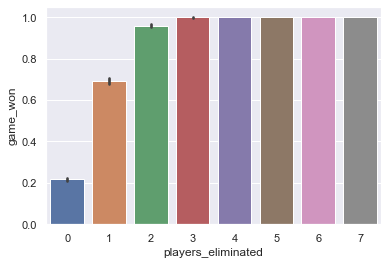

In [117]:
sns.barplot(x='players_eliminated', y='game_won', data=game_data)

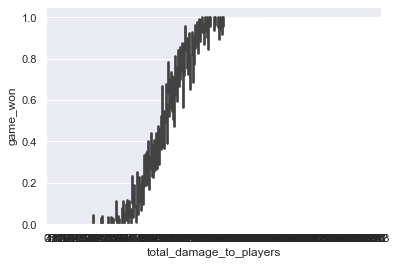

In [118]:
sns.barplot(x='total_damage_to_players', y='game_won', data=game_data)

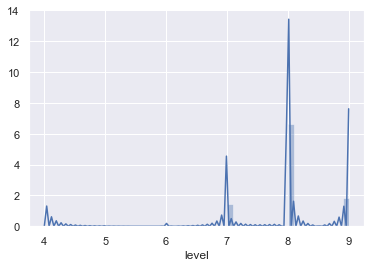

In [119]:
sns.distplot(game_data['level'], hist=True, kde=True, label = 'Level')

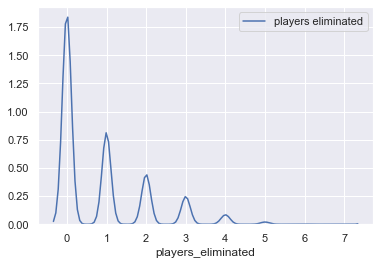

In [120]:
sns.distplot(game_data['players_eliminated'], hist=False, kde=True, label = 'players eliminated')

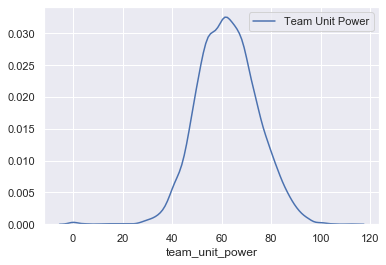

In [124]:
sns.distplot(game_data['team_unit_power'], hist=False, kde=True, label = 'Team Unit Power')

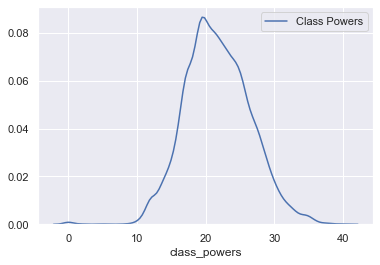

In [125]:
sns.distplot(game_data['class_powers'], hist=False, kde=True, label = 'Class Powers')

Text(0.5, 1.0, 'Class x Team Unit')

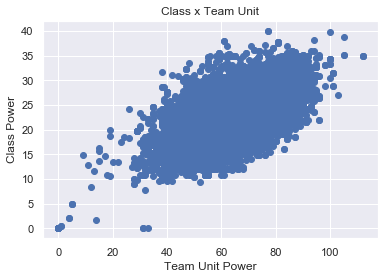

In [123]:
plt.scatter(x=game_data['team_unit_power'], y=game_data['class_powers'])
plt.xlabel("Team Unit Power")
plt.ylabel("Class Power")
plt.title("Class x Team Unit")

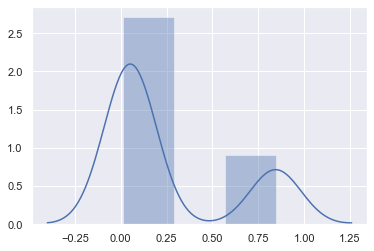

In [54]:
sns.distplot(model_xg.feature_importances_)